In [117]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

In [24]:
raw_data = pd.read_csv("Online_Retail.csv")
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [25]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
print(sales_data.info())
sales_data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB
None


RangeIndex(start=0, stop=541909, step=1)

In [122]:
def extract_product(product_id):
    #pull out all transactions of one product and drop StockCode
    product = sales_data.loc[sales_data['StockCode'] == product_id].drop('StockCode',axis=1)
    product=product.set_index(['InvoiceDate']) #Convert to timeseries 

    #DownSampling to a day
    day_summary = pd.DataFrame()
    day_summary['Quantity'] = product.Quantity.resample('D').sum()
    day_summary = day_summary.fillna(0) #replacing NaN with 0
    day_summary = day_summary.clip(0) #replace -ve values with 0

    day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
    day_summary['Quantity']+=1#ti avoid -inf while taking log transformation 
    print(day_summary.describe())
    #plot
    fig, ax1 = plt.subplots()
    ax1.plot(day_summary.index, day_summary['Quantity'])
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    # ax1.set_ylim(0,100)
    plt.show()
    return day_summary

         Quantity
count  364.000000
mean    38.774725
std     75.402054
min      1.000000
25%      1.000000
50%     15.000000
75%     37.000000
max    658.000000


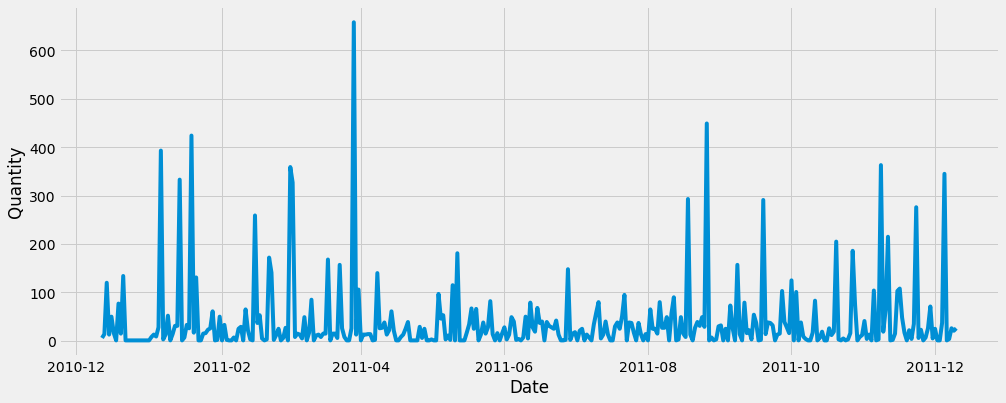

,Quantity
InvoiceDate,
2010-12-12,6.0
2010-12-13,14.0
2010-12-14,120.0
2010-12-15,13.0
2010-12-16,50.0


In [123]:
day_summary = extract_product('22629')
day_summary.head()

In [124]:
#required by prophet
day_summary.reset_index(inplace=True)
day_summary = day_summary.rename(columns={'Quantity': 'y','InvoiceDate': 'ds'})
day_summary.head()

,ds,y
0,2010-12-12,6.0
1,2010-12-13,14.0
2,2010-12-14,120.0
3,2010-12-15,13.0
4,2010-12-16,50.0


In [125]:
train,test = day_summary[:-10],day_summary[-10:]

In [126]:
train.head()

,ds,y
0,2010-12-12,6.0
1,2010-12-13,14.0
2,2010-12-14,120.0
3,2010-12-15,13.0
4,2010-12-16,50.0


In [127]:
test.head()

,ds,y
354,2011-12-01,25.0
355,2011-12-02,1.0
356,2011-12-03,1.0
357,2011-12-04,37.0
358,2011-12-05,345.0


In [128]:
my_model = Prophet()

In [129]:
my_model.fit(train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future_dates = my_model.make_future_dataframe(periods=10,freq='D')
future_dates.tail()

,ds
359,2011-12-06
360,2011-12-07
361,2011-12-08
362,2011-12-09
363,2011-12-10


In [131]:
forecast = my_model.predict(future_dates)
predicted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)
predicted

,ds,yhat,yhat_lower,yhat_upper
354,2011-12-01,61.361179,-27.373133,157.973148
355,2011-12-02,50.650980,-36.265291,142.642624
356,2011-12-03,11.885531,-79.914326,106.393841
357,2011-12-04,16.512297,-79.711979,109.257101
358,2011-12-05,29.773438,-63.808526,125.834610
359,2011-12-06,59.997336,-30.525496,153.486040
360,2011-12-07,45.365942,-50.049067,134.988604
361,2011-12-08,61.396024,-31.372637,147.084764
362,2011-12-09,50.685825,-43.006331,144.183641
363,2011-12-10,11.920376,-79.963278,106.185650


In [132]:
predicted = predicted[['ds','yhat']]
print(predicted)
print(test)

            ds       yhat
354 2011-12-01  61.361179
355 2011-12-02  50.650980
356 2011-12-03  11.885531
357 2011-12-04  16.512297
358 2011-12-05  29.773438
359 2011-12-06  59.997336
360 2011-12-07  45.365942
361 2011-12-08  61.396024
362 2011-12-09  50.685825
363 2011-12-10  11.920376
            ds      y
354 2011-12-01   25.0
355 2011-12-02    1.0
356 2011-12-03    1.0
357 2011-12-04   37.0
358 2011-12-05  345.0
359 2011-12-06    1.0
360 2011-12-07    4.0
361 2011-12-08   26.0
362 2011-12-09   21.0
363 2011-12-10   26.0


In [133]:
np.sqrt(mean_squared_error(test.y,predicted.yhat))

105.459741239544

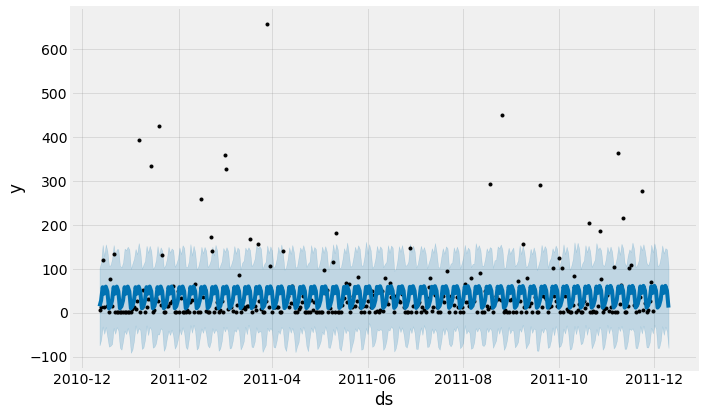

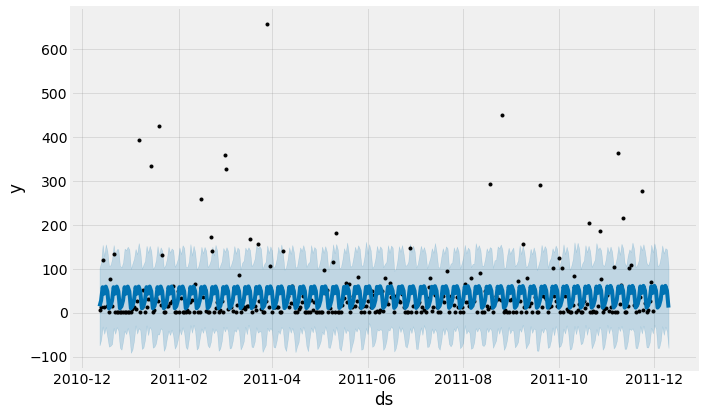

In [134]:
my_model.plot(forecast,uncertainty=True)